## 1. Problem Definition

This project addresses a **binary classification problem**:  
classifying emails as **spam** or **ham (not spam)**.

Spam detection is a real-world example of an **imbalanced dataset**, where:
- Most emails are legitimate (ham)
- A smaller portion are spam

Because of this imbalance, **accuracy alone is not a reliable metric**.
Instead, we focus on **precision, recall, and F1-score**, especially for the spam class.

In [7]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv("email.csv")

# Display first rows
df.head()



,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df.shape
df.info()
df['Category'].unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5573 entries, 0 to 5572
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Category  5573 non-null   object 
 1   Message   5573 non-null   object 
 2   label     5572 non-null   float64
dtypes: float64(1), object(2)
memory usage: 130.7+ KB


array(['ham', 'spam', '{"mode":"full"'], dtype=object)

In [9]:
# =========================
# 1. Imports
# =========================
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score
)

# =========================
# 2. Load dataset
# =========================
df = pd.read_csv("email.csv")

# =========================
# 3. Data cleaning (target variable)
# =========================
# Standardize labels
df['Category'] = df['Category'].astype(str).str.strip().str.lower()

# Keep only valid classes
df = df[df['Category'].isin(['ham', 'spam'])]

# =========================
# 4. Encode target variable
# =========================
df['label'] = df['Category'].map({'ham': 0, 'spam': 1})

# Safety check
assert df['label'].isna().sum() == 0, "NaN values found in label column"

# =========================
# 5. Inspect class distribution
# =========================
print("Class distribution (counts):")
print(df['label'].value_counts())

print("\nClass distribution (percentages):")
print((df['label'].value_counts(normalize=True) * 100).round(2))

# =========================
# 6. Train-test split
# =========================
X = df['Message']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# =========================
# 7. Majority class baseline model
# =========================
baseline_model = DummyClassifier(strategy="most_frequent")

baseline_model.fit(X_train, y_train)

y_pred_baseline = baseline_model.predict(X_test)

# =========================
# 8. Evaluation
# =========================
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_baseline))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_baseline))

print("\nAccuracy:")
print(accuracy_score(y_test, y_pred_baseline))


Class distribution (counts):
label
0    4825
1     747
Name: count, dtype: int64

Class distribution (percentages):
label
0    86.59
1    13.41
Name: proportion, dtype: float64

Confusion Matrix:
[[966   0]
 [149   0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       966
           1       0.00      0.00      0.00       149

    accuracy                           0.87      1115
   macro avg       0.43      0.50      0.46      1115
weighted avg       0.75      0.87      0.80      1115


Accuracy:
0.8663677130044843


d:\Python\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Python\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Python\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [10]:
# =========================
# 1. Imports
# =========================
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Perceptron
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score
)

# =========================
# 2. Load dataset
# =========================
df = pd.read_csv("email.csv")

# =========================
# 3. Data cleaning (target variable)
# =========================
df['Category'] = df['Category'].astype(str).str.strip().str.lower()

# Keep only valid labels
df = df[df['Category'].isin(['ham', 'spam'])]

# Encode target
df['label'] = df['Category'].map({'ham': 0, 'spam': 1})

# Safety check
assert df['label'].isna().sum() == 0, "NaN values found in label column"

# =========================
# 4. Train-test split
# =========================
X = df['Message']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# =========================
# 5. TF-IDF Vectorization
# =========================
tfidf = TfidfVectorizer(
    stop_words='english',
    max_features=3000
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# =========================
# 6. Perceptron Model
# =========================
perceptron = Perceptron(
    max_iter=1000,
    tol=1e-3,
    random_state=42,
    class_weight='balanced'
)

perceptron.fit(X_train_tfidf, y_train)

# =========================
# 7. Predictions
# =========================
y_pred = perceptron.predict(X_test_tfidf)

# =========================
# 8. Evaluation
# =========================
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy:")
print(accuracy_score(y_test, y_pred))


Confusion Matrix:
[[926  40]
 [  9 140]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       966
           1       0.78      0.94      0.85       149

    accuracy                           0.96      1115
   macro avg       0.88      0.95      0.91      1115
weighted avg       0.96      0.96      0.96      1115


Accuracy:
0.9560538116591928


In [11]:
# =========================
# 1. Imports
# =========================
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score
)

# =========================
# 2. Load dataset
# =========================
df = pd.read_csv("email.csv")

# =========================
# 3. Data cleaning (target variable)
# =========================
df['Category'] = df['Category'].astype(str).str.strip().str.lower()

# Keep only valid labels
df = df[df['Category'].isin(['ham', 'spam'])]

# Encode target
df['label'] = df['Category'].map({'ham': 0, 'spam': 1})

# Safety check
assert df['label'].isna().sum() == 0, "NaN values found in label column"

# =========================
# 4. Train-test split
# =========================
X = df['Message']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# =========================
# 5. TF-IDF Vectorization
# =========================
tfidf = TfidfVectorizer(
    stop_words='english',
    max_features=3000
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# =========================
# 6. Logistic Regression Model
# =========================
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)

log_reg.fit(X_train_tfidf, y_train)

# =========================
# 7. Predictions
# =========================
y_pred = log_reg.predict(X_test_tfidf)

# =========================
# 8. Evaluation
# =========================
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy:")
print(accuracy_score(y_test, y_pred))

# =========================
# 9. Explainability: Feature Importance
# =========================
feature_names = np.array(tfidf.get_feature_names_out())
coefficients = log_reg.coef_[0]

# Top words indicating spam
top_spam_words = feature_names[np.argsort(coefficients)[-15:]]

# Top words indicating ham
top_ham_words = feature_names[np.argsort(coefficients)[:15]]

print("Top spam-indicative words:")
print(top_spam_words)

print("\nTop ham-indicative words:")
print(top_ham_words)



Confusion Matrix:
[[951  15]
 [ 12 137]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       966
           1       0.90      0.92      0.91       149

    accuracy                           0.98      1115
   macro avg       0.94      0.95      0.95      1115
weighted avg       0.98      0.98      0.98      1115


Accuracy:
0.9757847533632287
Top spam-indicative words:
['won' '50' 'com' 'new' 'text' 'stop' '150p' 'free' 'service' 'reply'
 'www' 'claim' 'mobile' 'uk' 'txt']

Top ham-indicative words:
['ok' 'll' 'gt' 'lt' 'da' 'home' 'got' 'come' 'lor' 'sorry' 'hey' 'later'
 'way' 'sir' 'good']


Confusion Matrix:
[[962   4]
 [ 42 107]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       966
           1       0.96      0.72      0.82       149

    accuracy                           0.96      1115
   macro avg       0.96      0.86      0.90      1115
weighted avg       0.96      0.96      0.96      1115


Accuracy:
0.9587443946188341

ROC AUC score: 0.9689892589659148


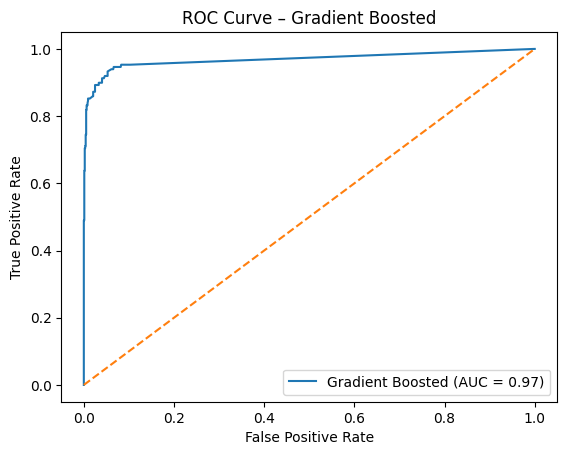

In [14]:
# =========================
# 1. Imports
# =========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    roc_curve,
    roc_auc_score
)

# =========================
# 2. Load dataset
# =========================
df = pd.read_csv("email.csv")

# =========================
# 3. Data cleaning (target variable)
# =========================
df['Category'] = df['Category'].astype(str).str.strip().str.lower()

# Keep only valid labels
df = df[df['Category'].isin(['ham', 'spam'])]

# Encode target
df['label'] = df['Category'].map({'ham': 0, 'spam': 1})

# Safety check
assert df['label'].isna().sum() == 0, "NaN values found in label column"

# =========================
# 4. Train-test split
# =========================
X = df['Message']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# =========================
# 5. TF-IDF Vectorization
# =========================
tfidf = TfidfVectorizer(
    stop_words='english',
    max_features=2000   # lower for tree-based models
)

X_train_tfidf = tfidf.fit_transform(X_train).toarray()
X_test_tfidf = tfidf.transform(X_test).toarray()

# =========================
# 6. Gradient Boosted Tree Model
# =========================
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

gb_model.fit(X_train_tfidf, y_train)

# =========================
# 7. Predictions
# =========================
y_pred = gb_model.predict(X_test_tfidf)
y_proba = gb_model.predict_proba(X_test_tfidf)[:, 1]  # probabilities for ROC

# =========================
# 8. Evaluation
# =========================
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy:")
print(accuracy_score(y_test, y_pred))

# =========================
# 9. ROC Curve & AUC
# =========================
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

print("\nROC AUC score:", roc_auc)

plt.figure()
plt.plot(fpr, tpr, label=f"Gradient Boosted (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Gradient Boosted")
plt.legend()
plt.show()
